In [1]:
# pip install bing_image_downloader
# pip install tensorflow_datasets
# pip install keras

In [123]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from bing_image_downloader import downloader
from keras.models import load_model
from PIL import Image

In [3]:
query_string = ["norwegian male", "norwegian female", "indian male", "indian female"]
output_dir='dataset'

In [4]:
# downloader.download(query_string, 
#                     limit=10000,  
#                     output_dir='dataset', 
#                     adult_filter_off=True, 
#                     force_replace=False, 
#                     timeout=60)

In [5]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [42]:
base_dir = pathlib.Path.cwd() / output_dir
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                               validation_split=VALIDATION_SPLIT,
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 10788 files for training.


In [44]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                              validation_split=VALIDATION_SPLIT,
                                                              subset='validation',
                                                              seed=123,
                                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 2697 files for validation.


In [45]:
class_names = train_ds.class_names
print(class_names)

['indian female', 'indian male', 'norwegian female', 'norwegian male']


### Visualizing the dataset

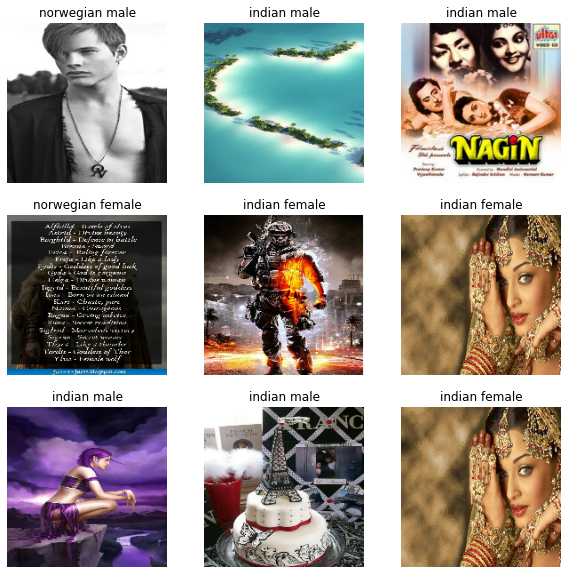

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to model.fit.
If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [48]:
for image_batch, labels_batch in train_ds:
    print(image_batch)
    print(labels_batch)
    print(len(image_batch))
    break

tf.Tensor(
[[[[103.49074    107.19907    112.546295  ]
   [ 93.75347     90.71875     85.36111   ]
   [ 69.41435     58.04051     39.592594  ]
   ...
   [102.98373     94.74761     91.27538   ]
   [ 86.93055     77.38888     70.22219   ]
   [ 92.23847     78.00233     70.696785  ]]

  [[127.44792    127.48958    131.80208   ]
   [112.34375    106.17708    101.635414  ]
   [ 78.170135    63.850693    47.048615  ]
   ...
   [ 90.94097     82.89583     78.73263   ]
   [ 85.06245     75.520775    68.12492   ]
   [123.035065   109.01073    101.28157   ]]

  [[131.0706     125.291664   128.13774   ]
   [126.111115   114.19444    107.02431   ]
   [119.76042     99.75463     83.615746  ]
   ...
   [ 80.56955     73.09732     66.733894  ]
   [124.56269    115.02102    106.89254   ]
   [139.13771    125.748795   116.59486   ]]

  ...

  [[121.28788    121.28788    119.28788   ]
   [133.95828    133.95828    131.95828   ]
   [131.89249    131.89249    129.89249   ]
   ...
   [111.59726    112.597

### Standardize the data

In [49]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [61]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [79]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [80]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [81]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
model.fit(train_ds,
          validation_data=test_ds,
          epochs=1)

169/169 [==============================] - 724s 4s/step - loss: 0.3817 - accuracy: 0.8648 - val_loss: 0.1360 - val_accuracy: 0.9614


### Test model on unknown dataset

In [152]:
file_name = "test1.jpg"

In [153]:
# set the width and height of the result
width = 180
height = 180
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 180, 180, 3])

In [154]:
# predict the test data
predict_class = model.predict_classes(test_image)

In [155]:
predict_class

array([1])